In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

/Users/GYUNAM/.pyenv/versions/3.4.5/lib/python3.4/importlib/_bootstrap.py:321: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  return f(*args, **kwds)


### Load MNIST Data

In [2]:
def batch_maker(batch_size, img, label):
    img_len = len(img)
    random_idx = np.random.randint(img_len, size = batch_size)
    return img[random_idx], label[random_idx]

In [3]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [4]:
train_idx = ((np.argmax(mnist.train.labels, 1) == 1) | \
             (np.argmax(mnist.train.labels, 1) == 5) | \
             (np.argmax(mnist.train.labels, 1) == 6))
test_idx = ((np.argmax(mnist.test.labels, 1) == 1) | \
            (np.argmax(mnist.test.labels, 1) == 5) | \
            (np.argmax(mnist.test.labels, 1) == 6))

train_imgs   = mnist.train.images[train_idx]
train_labels = mnist.train.labels[train_idx]
test_imgs    = mnist.test.images[test_idx]
test_labels  = mnist.test.labels[test_idx]
n_train      = train_imgs.shape[0]
n_test       = test_imgs.shape[0]

print ("Packages loaded")
print ("The number of trainimgs : {}, shape : {}".format(n_train, train_imgs.shape))
print ("The number of testimgs : {}, shape : {}".format(n_test, test_imgs.shape))

Packages loaded
The number of trainimgs : 16583, shape : (16583, 784)
The number of testimgs : 2985, shape : (2985, 784)


### 3.3. Define an Autoencoder Shape

In [5]:
# Shape of input and latent variable
n_input = 28*28

# Encoder shape
n_encoder1 = 500
n_encoder2 = 300

n_latent = 2

# Decoder shape
n_decoder1 = 300
n_decoder2 = 500

In [6]:

weights = {
    'encoder1' : tf.Variable(tf.random_normal([n_input, n_encoder1], stddev=0.1)),
    'encoder2' : tf.Variable(tf.random_normal([n_encoder1, n_encoder2], stddev=0.1)),
    'latent' : tf.Variable(tf.random_normal([n_encoder2, n_latent], stddev=0.1)),
    'decoder1' : tf.Variable(tf.random_normal([n_latent, n_decoder1], stddev=0.1)),
    'decoder2' : tf.Variable(tf.random_normal([n_decoder1, n_decoder2], stddev=0.1)),
    'reconst' : tf.Variable(tf.random_normal([n_decoder2, n_input], stddev=0.1))
}

biases = {
    'encoder1' : tf.Variable(tf.random_normal([n_encoder1], stddev=0.1)),
    'encoder2' : tf.Variable(tf.random_normal([n_encoder2], stddev=0.1)),
    'latent' : tf.Variable(tf.random_normal([n_latent], stddev=0.1)),
    'decoder1' : tf.Variable(tf.random_normal([n_decoder1], stddev=0.1)),
    'decoder2' : tf.Variable(tf.random_normal([n_decoder2], stddev=0.1)),
    'reconst' : tf.Variable(tf.random_normal([n_input], stddev=0.1))
}

x = tf.placeholder(tf.float32, [None, n_input])

In [7]:
def encoder(x, weights, biases):
    encoder1 = tf.add(tf.matmul(x, weights['encoder1']), biases['encoder1'])
    encoder1 = tf.nn.tanh(encoder1)
    
    encoder2 = tf.add(tf.matmul(encoder1, weights['encoder2']), biases['encoder2'])
    encoder2 = tf.nn.tanh(encoder2)
    
    latent = tf.add(tf.matmul(encoder2, weights['latent']), biases['latent'])

    return latent

In [8]:
def decoder(latent, weights, biases):
    decoder1 = tf.add(tf.matmul(latent, weights['decoder1']), biases['decoder1'])
    decoder1 = tf.nn.tanh(decoder1)
    
    decoder2 = tf.add(tf.matmul(decoder1, weights['decoder2']), biases['decoder2'])
    decoder2 = tf.nn.tanh(decoder2)
    
    reconst = tf.add(tf.matmul(decoder2, weights['reconst']), biases['reconst'])
   
    return reconst

### Define Loss, Initializer and Optimizer

In [9]:
LR = 0.0001

latent = encoder(x, weights, biases)
reconst = decoder(latent, weights, biases)
loss = tf.square(tf.subtract(x, reconst))
loss = tf.reduce_mean(loss)

optm = tf.train.AdamOptimizer(LR).minimize(loss)

init = tf.global_variables_initializer()

In [10]:
n_batch = 50
n_iter = 2500
n_prt = 250

### Optimization

In [11]:
# Run initialize
# config = tf.ConfigProto(allow_soft_placement=True)  # GPU Allocating policy
# sess = tf.Session(config=config)
sess = tf.Session()
sess.run(init)

# Training cycle
for epoch in range(n_iter):
    train_x, train_y = batch_maker(n_batch, train_imgs, train_labels)
    sess.run(optm, feed_dict={x : train_x})  
    
    if epoch % n_prt == 0:
        c = sess.run(loss, feed_dict={x: train_x})
        print ("Iter : {}".format(epoch))
        print ("Cost : {}".format(c))

Iter : 0
Cost : 0.4568221867084503
Iter : 250
Cost : 0.051486749202013016
Iter : 500
Cost : 0.04554536193609238
Iter : 750
Cost : 0.045209161937236786
Iter : 1000
Cost : 0.042274363338947296
Iter : 1250
Cost : 0.04059769585728645
Iter : 1500
Cost : 0.036596398800611496
Iter : 1750
Cost : 0.04157098010182381
Iter : 2000
Cost : 0.03605948016047478
Iter : 2250
Cost : 0.03660152480006218


### Test

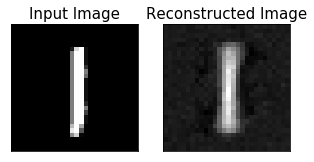

In [12]:
test_x, test_y = batch_maker(1, test_imgs, test_labels)
x_reconst = sess.run(reconst, feed_dict={x : test_x})

fig = plt.figure(figsize=(5, 3))
ax1 = fig.add_subplot(1, 2, 1)
ax1.imshow(test_x.reshape(28, 28), 'gray')
ax1.set_title('Input Image', fontsize=15)
ax1.set_xticks([])
ax1.set_yticks([])

ax2 = fig.add_subplot(1, 2, 2)
ax2.imshow(x_reconst.reshape(28, 28), 'gray')
ax2.set_title('Reconstructed Image', fontsize=15)
ax2.set_xticks([])
ax2.set_yticks([])
plt.show()

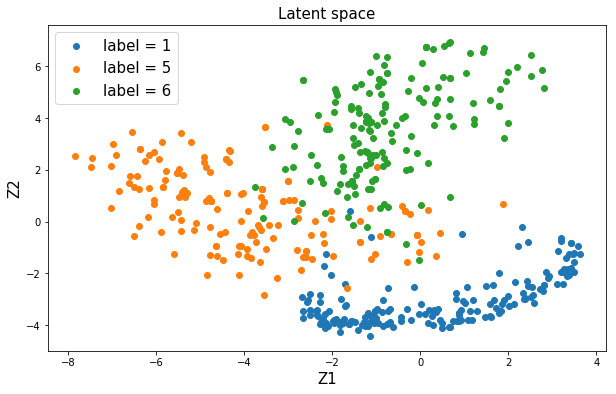

In [13]:
test_x, test_y = batch_maker(500, test_imgs, test_labels)
test_y = np.argmax(test_y, axis=1)
test_latent = sess.run(latent, feed_dict={x : test_x})

plt.figure(figsize=(10,6))
plt.scatter(test_latent[test_y == 1,0], test_latent[test_y == 1,1], label = 'label = 1')
plt.scatter(test_latent[test_y == 5,0], test_latent[test_y == 5,1], label = 'label = 5')
plt.scatter(test_latent[test_y == 6,0], test_latent[test_y == 6,1], label = 'label = 6')
plt.title('Latent space', fontsize=15)
plt.xlabel('Z1', fontsize=15)
plt.ylabel('Z2', fontsize=15)
plt.legend(fontsize = 15)
plt.show()

### Data Generation

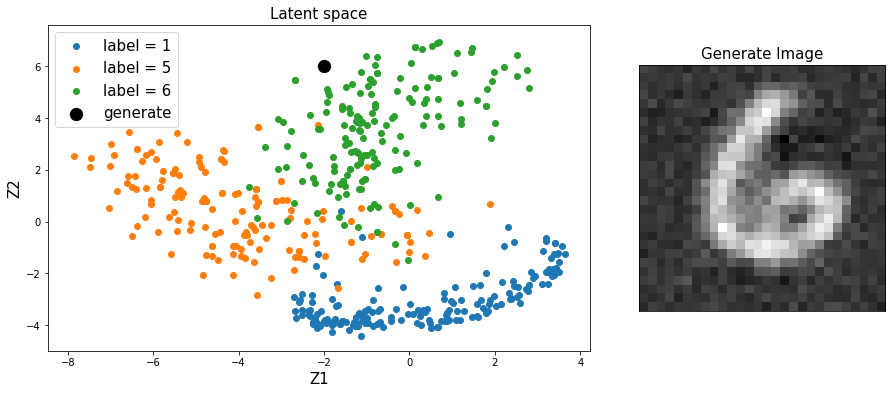

In [14]:
generate_data = np.array([[-2, 6]])

fig = plt.figure(figsize=(15,6))
ax = plt.subplot2grid((1,3), (0,0), colspan=2)
ax.scatter(test_latent[test_y == 1,0], test_latent[test_y == 1,1], label = 'label = 1')
ax.scatter(test_latent[test_y == 5,0], test_latent[test_y == 5,1], label = 'label = 5')
ax.scatter(test_latent[test_y == 6,0], test_latent[test_y == 6,1], label = 'label = 6')
ax.scatter(generate_data[:,0], generate_data[:,1], label = 'generate', s = 150, c = 'k', marker = 'o')
ax.set_title('Latent space', fontsize=15)
ax.set_xlabel('Z1', fontsize=15)
ax.set_ylabel('Z2', fontsize=15)
ax.legend(fontsize = 15)

latent_input = tf.placeholder(tf.float32, [None, n_latent])
reconst = decoder(latent_input, weights, biases)
generate_x = sess.run(reconst, feed_dict={latent_input : generate_data})


ax = plt.subplot2grid((1, 3), (0, 2), colspan=1)
ax.imshow(generate_x.reshape(28, 28), 'gray')
ax.set_title('Generate Image', fontsize=15)
ax.set_xticks([])
ax.set_yticks([])
plt.show()

### Visualization

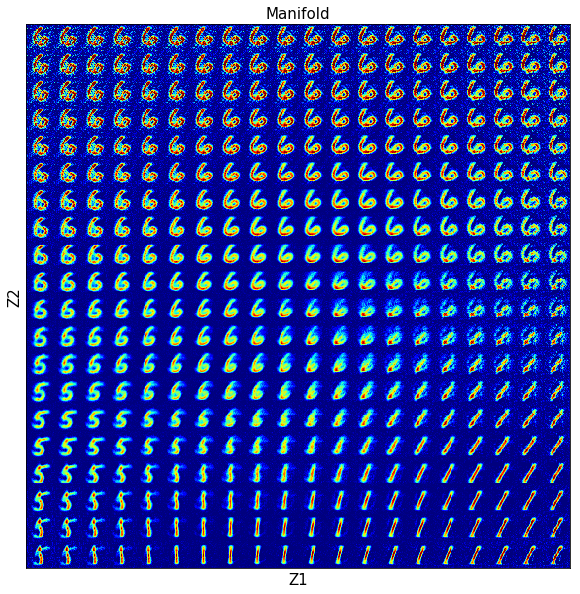

In [15]:
# Initialize canvas
nx = ny = 20
x_values = np.linspace(-4, 4, nx)
y_values = np.linspace(-4, 10, ny)
canvas = np.empty((28*ny, 28*nx))

# Define placeholder
latent_input = tf.placeholder(tf.float32, [None, n_latent])
reconst = decoder(latent_input, weights, biases)

for i, yi in enumerate(y_values):
        for j, xi in enumerate(x_values):
            latent_ = np.array([[xi, yi]])
            reconst_ = sess.run(reconst, feed_dict={latent_input : latent_})
            canvas[(nx-i-1)*28:(nx-i)*28,j*28:(j+1)*28] = reconst_.reshape(28, 28)

plt.figure(figsize=(10, 10))
plt.imshow(canvas, clim=(0, 1), cmap=plt.cm.jet)
plt.title('Manifold', fontsize=15)
plt.xticks([])
plt.xlabel('Z1', fontsize=15)
plt.yticks([])
plt.ylabel('Z2', fontsize=15)
plt.show()